# init

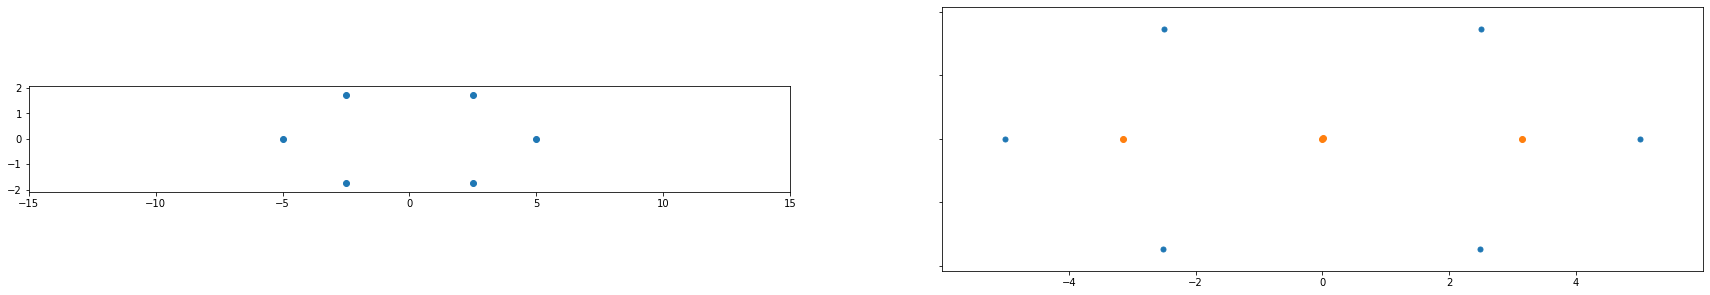

In [1]:
import sys 
sys.path.append('pyfiles/')
import classes as cl
# so we don't have to reboot kernel every time we modify classes.py
%load_ext autoreload
%autoreload 2

# math stuff
import numpy as np
# visualization
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import distance
from copy import deepcopy

import matplotlib.pyplot as plt
%matplotlib inline
# sliders
from ipywidgets import interactive

# for matrix import and display
import pandas as pd
from IPython.display import display_html 
import csv 

######## NOTE: from this point on, order is important. 
# it would be good to make the code more robust, but right
# now, there are ordered dependencies between functions.

points = cl.ellipse_example(numpts = 6)
# note: 100 pts causes handling error

[5.84, 0.62, 28.62, 61.84, 35.65, 7.55]


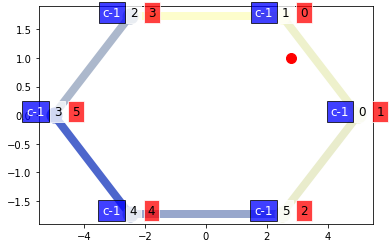

In [2]:
init_complex = cl.initcomplex(points)
s_complex = cl.complex()
s_complex.key_point = (2.8,1)

# update this to .self so don't need input, except maybe key pt
distlist = s_complex.find_sq_dist(init_complex)
cl.sort_complex(s_complex, distlist, plot = True)

# this is the permutation
all_simplices = s_complex.order_all_simps()
# I am pretty sure the simps are also ordered in s_complex, 
# not just all_simplices. make sure.
# dummy_simplex = cl.simplex()
# dummy_simplex.columnvalue = 0
# all_simplices.append(dummy_simplex)

In [3]:
# print(s_complex.vertlist)
# print(s_complex.edgelist)
# CHANGELOG: here, edges start at index 1, and previously they started at 0. Temp change to cl file 
# to see if it fixes error. l172 roughly, init_edges()
print(all_simplices)

[
simplex ind 1, dim 0, bd [-1], ord ind 0, col val 1, 
simplex ind 0, dim 0, bd [-1], ord ind 1, col val 2, 
simplex ind 0, dim 1, bd [0, 1], ord ind 1, col val 3, 
simplex ind 5, dim 0, bd [-1], ord ind 2, col val 4, 
simplex ind 5, dim 1, bd [5, 0], ord ind 2, col val 5, 
simplex ind 2, dim 0, bd [-1], ord ind 3, col val 6, 
simplex ind 1, dim 1, bd [1, 2], ord ind 3, col val 7, 
simplex ind 4, dim 0, bd [-1], ord ind 4, col val 8, 
simplex ind 4, dim 1, bd [4, 5], ord ind 4, col val 9, 
simplex ind 3, dim 0, bd [-1], ord ind 5, col val 10, 
simplex ind 2, dim 1, bd [2, 3], ord ind 5, col val 11, 
simplex ind 3, dim 1, bd [3, 4], ord ind 5, col val 12]


In [4]:
mat = cl.bdmatrix()
mat.make_matrix(s_complex)

mat.redmatrix = mat.reduce(display = False)


########### test
bd_pairs = {
    # initial index. we can't differentiate vert/edge this way,
    # but we can by knowing classdim, so it's fine.
    "birth": [],
    "death": [],
    # always the dim of the 
    # birth simplex. 
    # the death simplex has dim +1 from birth. 
    "classdim": [],
    "b_simplex": [],
    "d_simplex": []
}
unpaired = {
    # classdim is the same as dim of birth simplex.
    # this is needed also so we know if it's a vert or edge,
    # since the index alone doesn't tell us.
    "birth": [],
    "classdim": [],
    "b_simplex": []
}

############3
# this adds in a column for reduced homology
mat.add_dummy_col()
# do smart thing to get rid of all_simplices
# maybe keep a list on the complex class?
# I Think THE ERROR IS HERE. COL INDEX IS GETTING ASSIGNED WRONG.
mat.find_lows_zeros(all_simplices)

print("Zero Columns:")
for key, value in mat.zerocolumns.items():
    print(key, ":", value)
print("\nLowest Ones:")
for key, value in mat.lowestones.items():
    print(key, ":", value)
    

betti_dummy, betti_zero, betti_one = mat.find_bettis()

print("\nbetti dummy: ", betti_dummy, "\nbetti zero: ", betti_zero, "\nbetti one:" ,betti_one)
# print(all_simplices)

## ISSUE?!? I don't think col 14 would only have index of 4. 
# Should be 6, right?!
# print(all_simplices)
# ah, should be fine bc is initialization index, not ordered.

# ANOTHER ISSUE
# here, col index should be -1 if it's the emptyset, fix this

columns:  13  rows:  13
Zero Columns:
col : [0, 2, 4, 6, 8, 10, 12]
dim : [-1, 0, 0, 0, 0, 0, 1]
col_index : [-1, 0, 5, 2, 4, 3, 3]

Lowest Ones:
col : [1, 3, 5, 7, 9, 11]
row : [0, 2, 4, 6, 8, 10]
dim : [-1, 0, 0, 0, 0, 0]
col_index : [1, 0, 5, 1, 4, 2]
row_index : [-1, 0, 5, 2, 4, 3]

betti dummy:  0 
betti zero:  0 
betti one: 1


In [5]:
# we've counted birth death pairs, but now we
# need to add in inf persistence (unpaired)
died = True
i = 0
# j is row? I think
j = 0
for c in mat.zerocolumns["col"]:
    # this was the birth of an h class, so check if 
    # it is in row of lowest ones
    
    # col c in the matrix was a birth
    # so we should check corresponding row to see
    # if there is a bd pair there
    died = False
    # we assume first that it's an inf hom class (no death)
    for r in mat.lowestones["row"]:
        if r == c:
            died = True
#             # j is the index
#             j += 1
            # break here?!
            # this is an edit; didn't break previously
#             break
    # we found the birth value (r = c)
    # now we want the death value
    if died and j < len(mat.lowestones["row"]): 
        # recheck if all the dims are right. 
        # might have mixed up rows and cols.
        bd_pairs["classdim"].append(mat.zerocolumns["dim"][i])
        
        # NOTE: THIS IS PROBABLY WHERE THE PROBLEM IS
#         bd_pairs["death"].append(mat.lowestones["row_index"][j])
#         bd_pairs["birth"].append(mat.zerocolumns["col_index"][i])
        bd_pairs["death"].append(mat.lowestones["col_index"][j])
        bd_pairs["birth"].append(mat.zerocolumns["col_index"][i])
        # edit: just added incrementing j here. 
        # I think it was incr too often above in if statement
        # j is the index
        j += 1
        
        if mat.zerocolumns["dim"][i] == -1:
            bd_pairs["b_simplex"].append("emptyset")
            bd_pairs["d_simplex"].append("v")
        if mat.zerocolumns["dim"][i] == 0:
            bd_pairs["b_simplex"].append("v")
            bd_pairs["d_simplex"].append("e")
        if mat.zerocolumns["dim"][i] == 1:
            bd_pairs["b_simplex"].append("e")
    if died == False:
        # check here too.
#         unpaired["birth"].append(mat.zerocolumns["col_index"][i])
        # CHANGED
        unpaired["birth"].append(mat.zerocolumns["col_index"][i])
        unpaired["classdim"].append(mat.zerocolumns["dim"][i])
        if mat.zerocolumns["dim"][i] == -1:
            unpaired["b_simplex"].append("emptyset")
        if mat.zerocolumns["dim"][i] == 0:
            unpaired["b_simplex"].append("v")
        if mat.zerocolumns["dim"][i] == 1:
            unpaired["b_simplex"].append("e")
    i = i + 1
# print("\n",bd_pairs, "\n\n", unpaired)

In [6]:
print("birth death pairs")
for keys, value in bd_pairs.items():
   print(keys, value)
print("\n") 
print("infinite homology classes")
for keys, value in unpaired.items():
   print(keys, value)

# ISSUE: emptyset has index 0 ad we should index 
# it -1 for no confusion. find where index is given

# this should be initial index but maybe it's column value
# check if it's the ordered index as well

birth death pairs
birth [-1, 0, 5, 2, 4, 3]
death [1, 0, 5, 1, 4, 2]
classdim [-1, 0, 0, 0, 0, 0]
b_simplex ['emptyset', 'v', 'v', 'v', 'v', 'v']
d_simplex ['v', 'e', 'e', 'e', 'e', 'e']


infinite homology classes
birth [3]
classdim [1]
b_simplex ['e']


In [7]:
print("simplices labeled by initial val, not column:\n")
for i in range(len(bd_pairs["birth"])):
    print(bd_pairs["b_simplex"][i], 
          bd_pairs["birth"][i], 
          "birthed a",
          bd_pairs["classdim"][i], 
          "dim h class killed by",
          bd_pairs["d_simplex"][i], 
          bd_pairs["death"][i], 
         )
for i in range(len(unpaired["birth"])):
    print(unpaired["b_simplex"][i],
          unpaired["birth"][i],
          "birthed an infinite",
          unpaired["classdim"][i],
          "dim h class"
         )
    
# would be cool: replot the graph, but labeling mothers and murderers
# there is definitely a bug here because the indexing is messed up. 
# I think the issue comes from adding the empty set in, and I also think
# everything is correct at the matrix sorting step, so I think it's in 
# this file, rather than the classes.py file.

# issues: not only need to index chase, also need to keep track of h classes.
# maybe need a whole new class, like a classes class hehe
# because we need to say THIS class was birthed by x but now is by y, right?
# or is it enough that we track pairings of bd simplices?

simplices labeled by initial val, not column:

emptyset -1 birthed a -1 dim h class killed by v 1
v 0 birthed a 0 dim h class killed by e 0
v 5 birthed a 0 dim h class killed by e 5
v 2 birthed a 0 dim h class killed by e 1
v 4 birthed a 0 dim h class killed by e 4
v 3 birthed a 0 dim h class killed by e 2
e 3 birthed an infinite 1 dim h class


[5.84, 0.62, 28.62, 61.84, 35.65, 7.55]


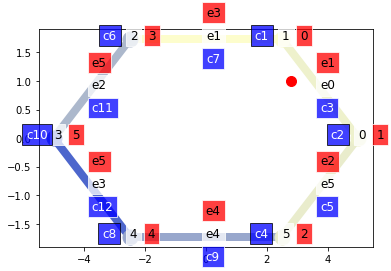

In [8]:
# should add a legend, but 
# white is sampling index
# red is dist to red pt
# blue is column assignment in matrix
s_complex.plot(extras = True, label_edges = True)

# ask herbert: 
1. can we guarantee there is always a lowest one in row 0? 
    I am pretty sure this is guaranteed if the simp cplx isn't empty, because there is always an empty set and it always gets killed immediately, right? relevant in 
    ```
        # I am pretty sure it is always first
        # I am also pretty sure there is always a 1 in row one
        self.lowestones["row_index"].append(-1)
        for j in range(length):
            # we know it's a square matrix by construction 
            for i in range(length):
    ```
    roughly l429, in find_lows_zeros(self,all_simps)
2. Birth death pairings are uniquely determined by column:row simplex indices, right? no need for thinking about Elder Rule? 
3. Also no need for thinking about Elder Rule when determining switches for vineyards, right? The way you determine a switch is by comparing pairings of b/d, and seeing which simplices are paired with which others, not by looking at for looking first at the ith homology class and the simplices which birth/kill it?